In [279]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from shapely.geometry import Point

In [280]:
# === 1. Carregamento dos dados ===
df = pd.read_csv("dataset_final_para_modelo.csv")

# Separar features e alvo
X = df.drop("Sinistro", axis=1)
y = df["Sinistro"]

In [281]:
# === 2. Limpeza e conversões ===
# Substitui vírgula por ponto em colunas numéricas que vieram como string
for col in df.columns:
    if df[col].dtype == 'object':
        # tenta converter
        df[col] = df[col].str.replace(',', '.', regex=False)
        # se der certo, converte para float
        try:
            df[col] = df[col].astype(float)
        except:
            pass  # mantém como texto se não for possível converter

df.loc[df['latitude'] <= -90, 'latitude'] = np.nan
df.loc[df['longitude'] <= -180, 'longitude'] = np.nan
df = df[df['latitude'].notna() & df['longitude'].notna()]


# Criação de uma GeoDataFrame com CRS (sistema de referência) WGS84  
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"  # WGS84 padrão
)

# Projeção para o sistema métrico da região de Bauru (UTM zona 23S)
gdf = gdf.to_crs("EPSG:32723")

# Extração das novas colunas X e Y (em metros)
df['x_coord'] = gdf.geometry.x
df['y_coord'] = gdf.geometry.y

scaler = MinMaxScaler()
df.loc[df['latitude'] <= -90, 'latitude'] = np.nan
df.loc[df['longitude'] <= -180, 'longitude'] = np.nan



df[['x_coord', 'y_coord']] = scaler.fit_transform(df[['x_coord', 'y_coord']])
df[['latitude', 'longitude', 'x_coord', 'y_coord']].head()

,latitude,longitude,x_coord,y_coord
0,-22.370454,-49.051246,0.097708,0.775890
1,-22.371995,-49.025240,0.107351,0.775267
2,-22.340207,-49.114017,0.074144,0.795953
3,-22.332466,-49.056129,0.095493,0.802394
4,-22.323449,-49.058255,0.094610,0.808668


In [282]:
# === 3. Separar X e y ===
y = df['Sinistro']
X = df.drop('Sinistro', axis=1)

# Identificar tipos de colunas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [283]:
# === 4. Pré-processamento ===
# Padroniza numéricas e cria dummies para categóricas
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [284]:
# === 5. Divisão treino/teste ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [285]:
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('xgb', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=8,
        min_child_weight=1,
        gamma=0.2,
        subsample=0.9,
        colsample_bytree=0.6,
        reg_alpha=0,
        reg_lambda=1,
        #scale_pos_weight=3.007099035933392,  # valor do gridsearch
        scale_pos_weight=5, 
        eval_metric="aucpr",
        random_state=42
    ))
])

In [286]:
# === 7. Treinamento ===
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      4902
           1       0.68      0.81      0.74      2445

    accuracy                           0.81      7347
   macro avg       0.78      0.81      0.79      7347
weighted avg       0.82      0.81      0.81      7347

Curva ROC - AUC:0.904

=== MATRIZ DE CONFUSÃO ===
TN: 3952, FP: 950, FN: 467, TP: 1978


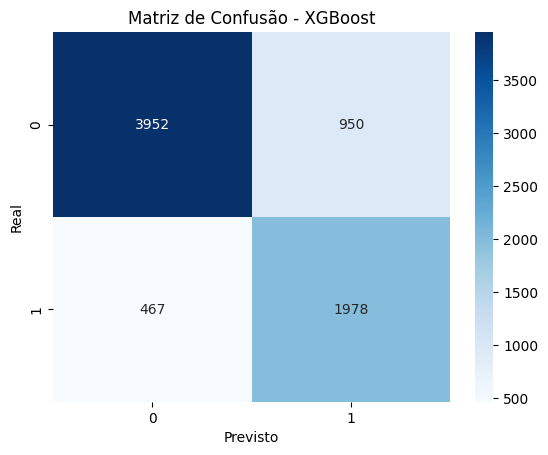

In [287]:
# === 8. Avaliação ===
y_prob = model.predict_proba(X_test)[:, 1]
threshold = 0.64  # reduzido para aumentar sensibilidade
y_pred = (y_prob >= threshold).astype(int)

print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))
print(f'Curva ROC - AUC:{roc_auc_score(y_test, y_prob):.3f}')

print("\n=== MATRIZ DE CONFUSÃO ===")
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()